In [1]:
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras.objectives import binary_crossentropy
from keras.callbacks import LearningRateScheduler

import numpy as np
import matplotlib.pyplot as plt
import keras.backend as K
import tensorflow as tf

Using TensorFlow backend.


In [11]:
m = 100
n_z = 2
n_epoch = 10


# Q(z|X) -- encoder
inputs = Input(shape=(784,))
h_q = Dense(256, activation='relu')(inputs)
mu = Dense(n_z, activation='relu')(h_q)
log_sigma = Dense(n_z, activation='relu')(h_q)

In [29]:
print z

Tensor("lambda_4/add:0", shape=(100, 2), dtype=float32)


In [27]:
def sample_z(args):
    mu, log_sigma = args
    eps = K.random_normal(shape=(m, n_z), mean=0., stddev=1.)
    return mu + K.exp(log_sigma / 2) * eps


# Sample z ~ Q(z|X)
z = Lambda(sample_z)([mu, log_sigma])
# P(X|z) -- decoder
decoder_hidden = Dense(256, activation='relu')
decoder_out = Dense(784, activation='relu')

h_p = decoder_hidden(z)
outputs = decoder_out(h_p)


In [13]:
# Overall VAE model, for reconstruction and training
vae = Model(inputs, outputs)

# Encoder model, to encode input into latent variable
# We use the mean as the output as it is the center point, the representative of the gaussian
encoder = Model(inputs, mu)

# Generator model, generate new data given latent variable z
d_in = Input(shape=(n_z,))
d_h = decoder_hidden(d_in)
d_out = decoder_out(d_h)
decoder = Model(d_in, d_out)


In [16]:
def vae_loss(y_true, y_pred):
    """ Calculate loss = reconstruction loss + KL loss for each data in minibatch """
    # E[log P(X|z)]
    recon = K.sum(K.binary_crossentropy(y_pred, y_true), axis=1)
    # D_KL(Q(z|X) || P(z|X)); calculate in closed form as both dist. are Gaussian
    kl = 0.5 * K.sum(K.exp(log_sigma) + K.square(mu) - 1. - log_sigma, axis=1)

    return K.mean(recon + kl)

In [9]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train_re = x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2])
x_test_re = x_test.reshape(x_test.shape[0], x_test.shape[1]*x_test.shape[2])
print x_train_re.shape
print x_test_re.shape

(60000, 784)
(10000, 784)


In [17]:
vae.compile(optimizer='adagrad', loss=vae_loss)
vae.fit(x_train_re > 0.5, x_train_re > 0.5, batch_size=m, nb_epoch=n_epoch)

/data1/groups/NextGenWeather_shared/sw/python/python2.7/gcc7.1.1/lib/python2.7/site-packages/ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/10
60000/60000 [==============================] - 7s - loss: -89627059752.9600     
Epoch 2/10
60000/60000 [==============================] - 7s - loss: -125776959699.6267     
Epoch 3/10
60000/60000 [==============================] - 7s - loss: -157055216872.1067     
Epoch 4/10
60000/60000 [==============================] - 7s - loss: -187588326331.7333     
Epoch 5/10
60000/60000 [==============================] - 7s - loss: -218330400098.9867     
Epoch 6/10
60000/60000 [==============================] - 7s - loss: -249661578581.3333     
Epoch 7/10
60000/60000 [==============================] - 7s - loss: -281773614530.5600     
Epoch 8/10
60000/60000 [==============================] - 7s - loss: -314794743480.3200     
Epoch 9/10
60000/60000 [==============================] - 7s - loss: -348795232638.2933     
Epoch 10/10
60000/60000 [==============================] - 7s - loss: -383820458912.4267     


In [19]:
z = encoder.predict(x_test_re > 0.5)
print z.shape

(10000, 2)


<IPython.core.display.Javascript object>


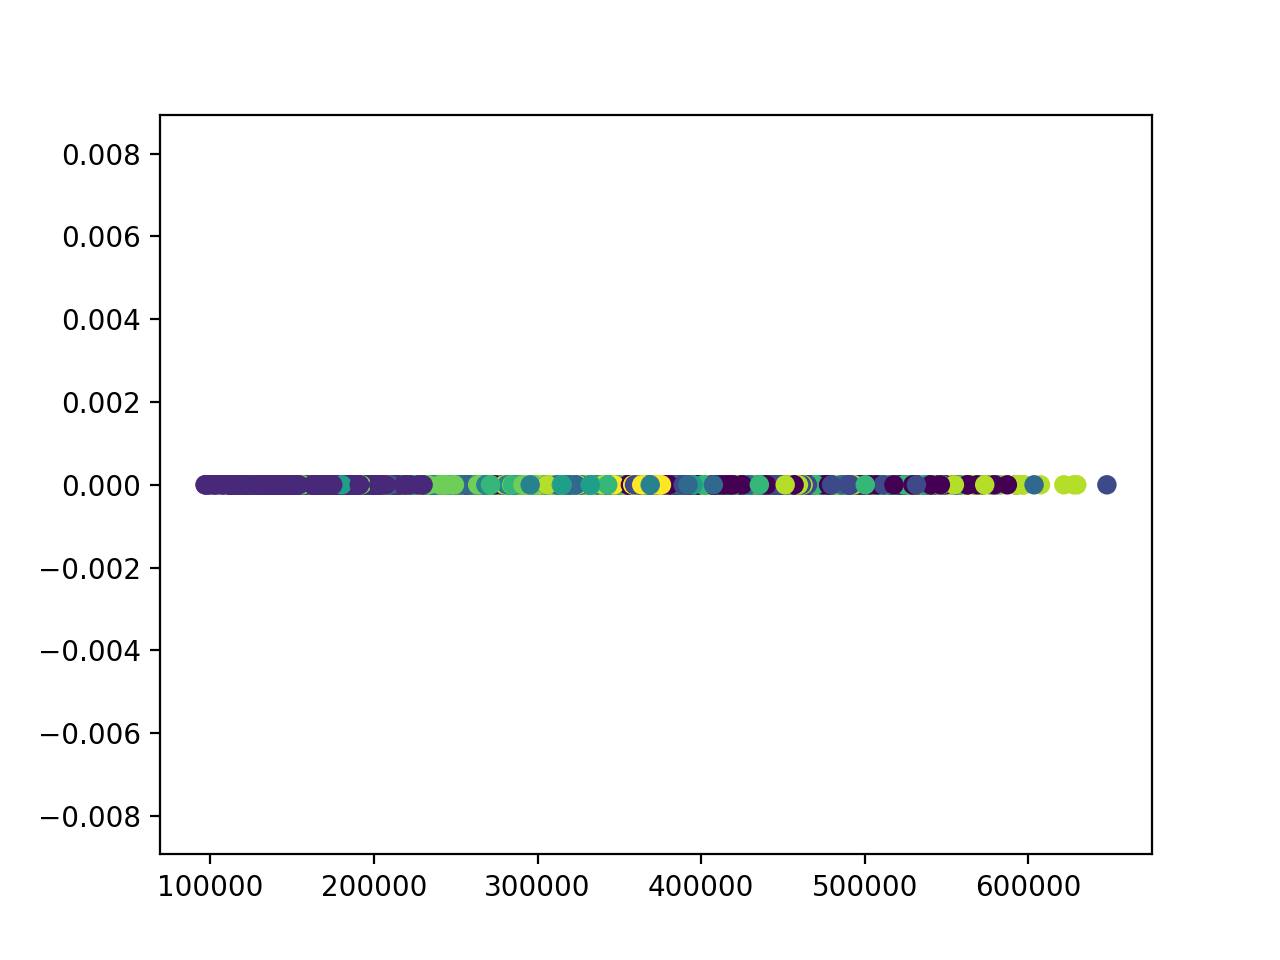

In [20]:
%matplotlib notebook
plt.scatter(z[:,0],z[:,1], c=y_test)
plt.show()